In [1]:
import os
import joblib
import pickle
import numpy as np
import tensorflow as tf
import support_functions as sf
import matplotlib.pyplot as plt
import keras.layers as layers
import sklearn.model_selection as model_selection

from glob import glob
from IPython import display
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from keras import Sequential, Model
from keras.callbacks import Callback

In [2]:
# GPU
sf.limit_gpu_memory(8 * 1024)
sf.gpu_check()

True

## Business Understanding
Bij het trainen van een model zijn de effecten meestal niet direct zichtbaar na de eerste 5 epochs. Grote verschillen zijn meestal pas na grotere tijdsintervallen te zien. Om die reden is het goed om te experimenteren met verschillende modelopstellingen op grotere schaal.

Er zijn verschillende grootschalige training uitgevoerd en onderzocht in Grote_Training.ipynb en Medium_Training.ipynb. In deze notebooks wordt zowel een Analyzer als een Reconstructor getrained in verschillende opstellingen. Deze bleken beiden op een NaN resultaat te komen. In dit notebook wordt om die reden een activatie functie toegevoegd. Het gaat dan om de functie 'relu'. Deze zorgt ervoor dat weights niet negatief kunnen worden. Op het moment dat ze negatief worden, worden ze omgezet naar een 0. Hiermee worden mogelijk uitschieters tegen gegaan en zou het kunnen dat we een beter resultaat creeëren.

In dit notebook wordt er gebruikt gemaakt van de volgende trainings opstelling:

Learning rate: 0.001

Analyser:

    Conv2D,
    Conv2D,
    Conv2D,
    MaxPooling2D,
    
    Conv2D,
    Conv2D,
    Conv2D,
    MaxPooling2D
    
    Conv2D,
    Conv2D,
    Conv2D,
    MaxPooling2D,
    
Reconstructor:

    Conv2DTranspose,
    Conv2DTranspose,
    Conv2DTranspose,
    Conv2D

Bij iedere Conv2D en Conv2DTranspose layer wordt in tegenstelling tot de vorige onderzoeken de activatie functie 'relu' toegepast. Wellicht dat dit een verschil in resultaat gaat opleveren en het model weghoud bij de NaN waarden.

---
#### Dit notebook is opgebouwd uit de volgende bronnen:
- N02. Inlezen data (loading) v3.0.ipynb van Chula Bruggeling (Data Understanding)
- read_dicom_files.ipynb van Dr. Paul Hiemstra (Data Understanding)
- split_models.ipynb van Vincent Dorenbosch (Data Preperation)
- split_models.ipynb van Vincent Dorenbosch (Modelling)
- Grote_Training.ipynb van Youri de Beurs (Modelling)
- Medium_Training.ipynb van Youri de Beurs (Modelling)
- triplets.ipynb van Hein Kamphuis (Evaluation)
- Trainings_Video.ipynb van Youri de Beurs (Evaluation)

## Data preparation

In [3]:
# Read slices
SLICES_JOBLIB_PATH = os.path.join('scans','scans_max_normalised_float32.joblib')

slices = joblib.load(SLICES_JOBLIB_PATH)

In [4]:
# Corrupt scans
NUMBER_OF_SWITCHES = 10
PATCH_SIZE = 32

corrupted_slices = np.array([sf.corrupt_image(slice, NUMBER_OF_SWITCHES, PATCH_SIZE) for slice in slices])

In [5]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(corrupted_slices, slices, test_size=0.2)

X_train = np.resize(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
y_train = np.resize(y_train, (y_train.shape[0], y_train.shape[1], y_train.shape[2], 1))

X_test = np.resize(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))
y_test = np.resize(y_test, (y_test.shape[0], y_test.shape[1], y_test.shape[2], 1))

## Modelling

In [6]:
# Use mulitple GPU's
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [7]:
with strategy.scope():
    analyzer = Sequential(
        [
            layers.Conv2D(128, kernel_size=3, input_shape=(512,512,1), padding='same', activation='relu'),
            layers.Conv2D(128, kernel_size=3, padding='same', activation='relu'),
            layers.Conv2D(128, kernel_size=3, padding='same', activation='relu'),
            layers.MaxPooling2D(),

            layers.Conv2D(256, kernel_size=3, padding='same', activation='relu'),
            layers.Conv2D(256, kernel_size=3, padding='same', activation='relu'),
            layers.Conv2D(256, kernel_size=3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            
            layers.Conv2D(256, kernel_size=3, padding='same', activation='relu'),
            layers.Conv2D(256, kernel_size=3, padding='same', activation='relu'),
            layers.Conv2D(256, kernel_size=3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
        ],
        name="analyzer",
    )
    analyzer.summary()

Model: "analyzer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 512, 512, 128)     1280      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 128)     147584    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 512, 512, 128)     147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 128)     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 256)     295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 256, 256, 256)     590080    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 256, 256, 256)     590

In [8]:
with strategy.scope():
    reconstructor = Sequential(
        [
            layers.Conv2DTranspose(512, kernel_size=3, strides=2, padding='same', input_shape=(64, 64, 256), activation='relu'),
            layers.Conv2DTranspose(256, kernel_size=3, strides=2, padding='same', activation='relu'),
            layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same', activation='relu'),
            layers.Conv2D(1, kernel_size=3, padding='same', activation='relu'),
        ],
        name="reconstructor",
    )
    reconstructor.summary()

Model: "reconstructor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTran (None, 128, 128, 512)     1180160   
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 256, 256, 256)     1179904   
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 512, 512, 128)     295040    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 512, 512, 1)       1153      
Total params: 2,656,257
Trainable params: 2,656,257
Non-trainable params: 0
_________________________________________________________________


In [9]:
with strategy.scope():
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    out_analyzer = analyzer.output
    out_final = reconstructor(out_analyzer)
    model = Model(analyzer.input, out_final)
    
    model.compile(optimizer=opt, loss='mse')

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [10]:
MODEL_NAME = 'medium_model_LR_0.001_2'
CALLBACK_INTERVAL = 5

model_folder = os.path.join('models', MODEL_NAME)
os.makedirs(model_folder, exist_ok=True)

image = y_train[0]
image_corrupt = sf.corrupt_image(image, NUMBER_OF_SWITCHES, PATCH_SIZE)
image_corrupt_expanded = np.resize(image_corrupt, (1, image_corrupt.shape[0], image_corrupt.shape[1], 1))

plt.imsave(os.path.join(model_folder, 'image.png'), np.resize(image, (image.shape[0], image.shape[1])), cmap=plt.cm.gray)
plt.imsave(os.path.join(model_folder, 'image_corrupt.png'), np.resize(image_corrupt, (image_corrupt.shape[0], image_corrupt.shape[1])), cmap=plt.cm.gray)

class PredictionCallback(Callback):    
  def on_epoch_end(self, epoch, logs={}):
    if (epoch % CALLBACK_INTERVAL == 0):
        image_predict = model.predict(image_corrupt_expanded)[0]
        sf.display_triplets(image, image_corrupt, image_predict)
        
        image_path = os.path.join(model_folder, f'{epoch:06d}.png')
        plt.imsave(image_path, np.resize(image_predict, (image_predict.shape[0], image_predict.shape[1])), cmap=plt.cm.gray)
        
class ModelSaveCallback(Callback):    
  def on_epoch_end(self, epoch, logs={}):
    if (epoch % CALLBACK_INTERVAL == 0):
        analyzer.save(os.path.join(model_folder, 'analyzer.h5'))
        reconstructor.save(os.path.join(model_folder, 'reconstructor.h5'))
        model.save(os.path.join(model_folder, 'complete.h5'))
        

custom_callbacks = [
    PredictionCallback(),
    ModelSaveCallback()
]

Epoch 1/500
INFO:tensorflow:batch_all_reduce: 26 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 26 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
51/51 [==============================] - ETA: 0s - loss: 0.0595INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/ta

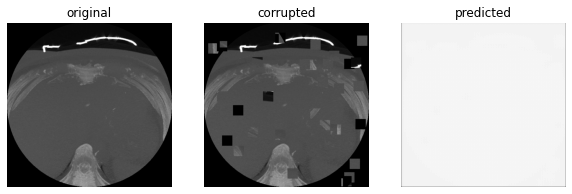

Epoch 2/500
51/51 [==============================] - 17s 330ms/step - loss: 0.0198 - val_loss: 0.0198
Epoch 3/500
51/51 [==============================] - 17s 330ms/step - loss: 0.0159 - val_loss: 0.0060
Epoch 4/500
51/51 [==============================] - 17s 331ms/step - loss: 0.0057 - val_loss: 0.0052
Epoch 5/500
51/51 [==============================] - 17s 332ms/step - loss: 0.0050 - val_loss: 0.0028
Epoch 6/500
51/51 [==============================] - 17s 331ms/step - loss: 0.0025 - val_loss: 0.0019


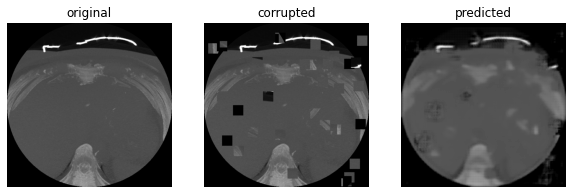

Epoch 7/500
51/51 [==============================] - 17s 331ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 8/500
51/51 [==============================] - 17s 331ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 9/500
51/51 [==============================] - 17s 333ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 10/500
51/51 [==============================] - 17s 332ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 11/500
51/51 [==============================] - 17s 333ms/step - loss: 0.0013 - val_loss: 0.0012


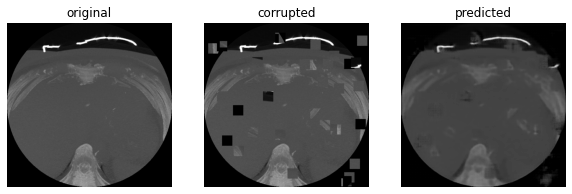

Epoch 12/500
51/51 [==============================] - 17s 333ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 13/500
51/51 [==============================] - 17s 332ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 14/500
51/51 [==============================] - 17s 333ms/step - loss: 0.0010 - val_loss: 9.5677e-04
Epoch 15/500
51/51 [==============================] - 17s 333ms/step - loss: 9.8278e-04 - val_loss: 9.0886e-04
Epoch 16/500
51/51 [==============================] - 17s 333ms/step - loss: 9.2192e-04 - val_loss: 8.5441e-04


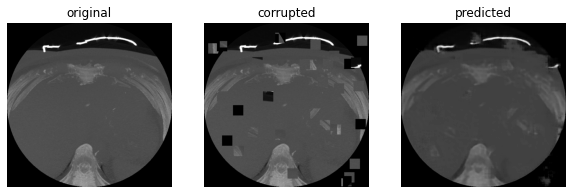

Epoch 17/500
51/51 [==============================] - 17s 333ms/step - loss: 9.1446e-04 - val_loss: 0.0011
Epoch 18/500
51/51 [==============================] - 17s 333ms/step - loss: 8.5035e-04 - val_loss: 8.4450e-04
Epoch 19/500
51/51 [==============================] - 17s 333ms/step - loss: 7.8988e-04 - val_loss: 8.4362e-04
Epoch 20/500
51/51 [==============================] - 17s 333ms/step - loss: 7.6513e-04 - val_loss: 9.0620e-04
Epoch 21/500
51/51 [==============================] - 17s 332ms/step - loss: 7.7672e-04 - val_loss: 7.4331e-04


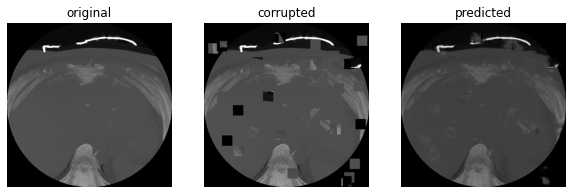

Epoch 22/500
51/51 [==============================] - 17s 332ms/step - loss: 6.7536e-04 - val_loss: 7.3057e-04
Epoch 23/500
51/51 [==============================] - 17s 333ms/step - loss: 6.5885e-04 - val_loss: 7.4105e-04
Epoch 24/500
51/51 [==============================] - 17s 333ms/step - loss: 6.5243e-04 - val_loss: 6.6633e-04
Epoch 25/500
51/51 [==============================] - 17s 332ms/step - loss: 5.9863e-04 - val_loss: 7.3183e-04
Epoch 26/500
51/51 [==============================] - 17s 336ms/step - loss: 5.9172e-04 - val_loss: 6.7686e-04


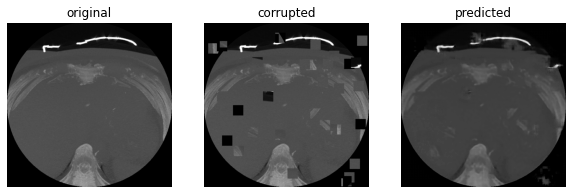

Epoch 27/500
51/51 [==============================] - 17s 333ms/step - loss: 5.5338e-04 - val_loss: 6.5625e-04
Epoch 28/500
51/51 [==============================] - 17s 334ms/step - loss: 5.3974e-04 - val_loss: 6.5499e-04
Epoch 29/500
51/51 [==============================] - 17s 333ms/step - loss: 5.1492e-04 - val_loss: 6.3742e-04
Epoch 30/500
51/51 [==============================] - 17s 333ms/step - loss: 4.9078e-04 - val_loss: 6.1439e-04
Epoch 31/500
51/51 [==============================] - 17s 333ms/step - loss: 4.7695e-04 - val_loss: 6.0968e-04


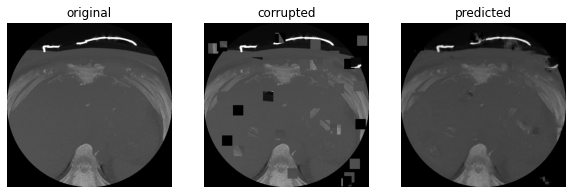

Epoch 32/500
51/51 [==============================] - 17s 333ms/step - loss: 4.6660e-04 - val_loss: 5.9959e-04
Epoch 33/500
51/51 [==============================] - 17s 334ms/step - loss: 4.3891e-04 - val_loss: 5.8900e-04
Epoch 34/500
51/51 [==============================] - 17s 333ms/step - loss: 4.7504e-04 - val_loss: 5.9862e-04
Epoch 35/500
51/51 [==============================] - 17s 333ms/step - loss: 4.1842e-04 - val_loss: 6.0075e-04
Epoch 36/500
51/51 [==============================] - 17s 333ms/step - loss: 4.1645e-04 - val_loss: 5.8956e-04


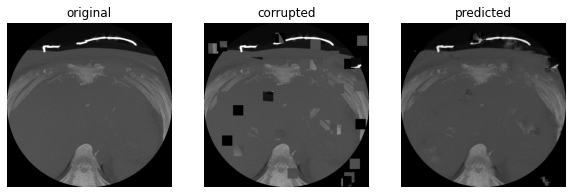

Epoch 37/500
51/51 [==============================] - 17s 333ms/step - loss: 3.8311e-04 - val_loss: 5.8187e-04
Epoch 38/500
51/51 [==============================] - 17s 333ms/step - loss: 3.7892e-04 - val_loss: 5.5350e-04
Epoch 39/500
51/51 [==============================] - 17s 333ms/step - loss: 3.6063e-04 - val_loss: 5.5783e-04
Epoch 40/500
51/51 [==============================] - 17s 333ms/step - loss: 3.7219e-04 - val_loss: 6.7766e-04
Epoch 41/500
51/51 [==============================] - 17s 333ms/step - loss: 3.8111e-04 - val_loss: 5.8036e-04


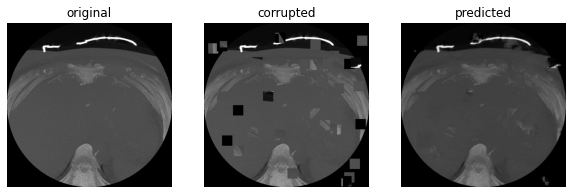

Epoch 42/500
51/51 [==============================] - 17s 333ms/step - loss: 3.5915e-04 - val_loss: 5.5787e-04
Epoch 43/500
51/51 [==============================] - 17s 333ms/step - loss: 3.2375e-04 - val_loss: 5.3669e-04
Epoch 44/500
51/51 [==============================] - 17s 333ms/step - loss: 3.1228e-04 - val_loss: 5.7968e-04
Epoch 45/500
51/51 [==============================] - 17s 333ms/step - loss: 3.0934e-04 - val_loss: 5.1777e-04
Epoch 46/500
51/51 [==============================] - 17s 335ms/step - loss: 2.9297e-04 - val_loss: 5.2489e-04


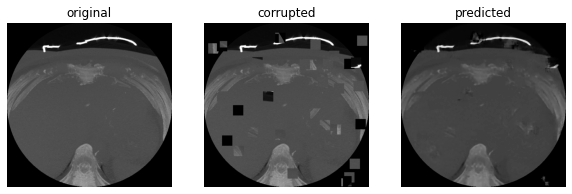

Epoch 47/500
51/51 [==============================] - 17s 332ms/step - loss: 3.0540e-04 - val_loss: 5.2673e-04
Epoch 48/500
51/51 [==============================] - 17s 332ms/step - loss: 2.8746e-04 - val_loss: 5.1356e-04
Epoch 49/500
51/51 [==============================] - 17s 333ms/step - loss: 2.7621e-04 - val_loss: 5.1987e-04
Epoch 50/500
51/51 [==============================] - 17s 332ms/step - loss: 2.7461e-04 - val_loss: 5.8469e-04
Epoch 51/500
51/51 [==============================] - 17s 333ms/step - loss: 3.2883e-04 - val_loss: 5.8927e-04


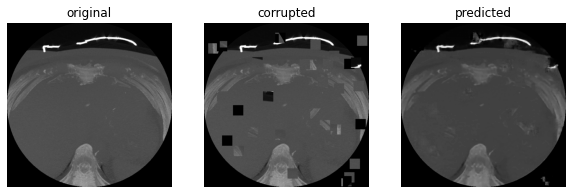

Epoch 52/500
51/51 [==============================] - 17s 333ms/step - loss: 3.2336e-04 - val_loss: 5.2959e-04
Epoch 53/500
51/51 [==============================] - 17s 333ms/step - loss: 2.6542e-04 - val_loss: 4.9454e-04
Epoch 54/500
51/51 [==============================] - 17s 333ms/step - loss: 2.4976e-04 - val_loss: 5.0339e-04
Epoch 55/500
51/51 [==============================] - 17s 333ms/step - loss: 2.4294e-04 - val_loss: 4.8598e-04
Epoch 56/500
51/51 [==============================] - 17s 333ms/step - loss: 2.4217e-04 - val_loss: 4.9147e-04


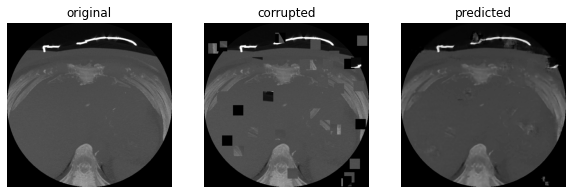

Epoch 57/500
51/51 [==============================] - 17s 333ms/step - loss: 2.3811e-04 - val_loss: 5.5641e-04
Epoch 58/500
51/51 [==============================] - 17s 333ms/step - loss: 3.6200e-04 - val_loss: 5.7277e-04
Epoch 59/500
51/51 [==============================] - 17s 333ms/step - loss: 2.8377e-04 - val_loss: 5.2572e-04
Epoch 60/500
51/51 [==============================] - 17s 333ms/step - loss: 2.4553e-04 - val_loss: 5.0407e-04
Epoch 61/500
51/51 [==============================] - 17s 333ms/step - loss: 2.3203e-04 - val_loss: 4.8032e-04


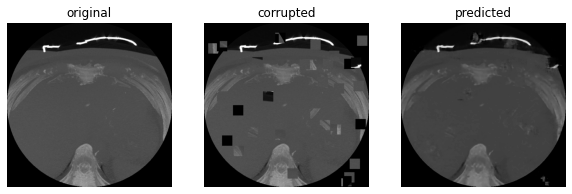

Epoch 62/500
51/51 [==============================] - 17s 332ms/step - loss: 2.1765e-04 - val_loss: 4.7769e-04
Epoch 63/500
51/51 [==============================] - 17s 333ms/step - loss: 2.1400e-04 - val_loss: 4.8002e-04
Epoch 64/500
51/51 [==============================] - 17s 333ms/step - loss: 2.2361e-04 - val_loss: 4.9984e-04
Epoch 65/500
51/51 [==============================] - 17s 334ms/step - loss: 4.0986e-04 - val_loss: 5.9778e-04
Epoch 66/500
51/51 [==============================] - 17s 333ms/step - loss: 3.1604e-04 - val_loss: 5.2415e-04


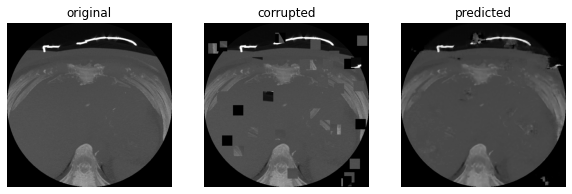

Epoch 67/500
51/51 [==============================] - 17s 334ms/step - loss: 2.5438e-04 - val_loss: 5.0017e-04
Epoch 68/500
51/51 [==============================] - 17s 334ms/step - loss: 2.2584e-04 - val_loss: 4.7311e-04
Epoch 69/500
51/51 [==============================] - 17s 333ms/step - loss: 2.0710e-04 - val_loss: 4.6860e-04
Epoch 70/500
51/51 [==============================] - 17s 333ms/step - loss: 2.0899e-04 - val_loss: 4.6648e-04
Epoch 71/500
51/51 [==============================] - 17s 333ms/step - loss: 1.9776e-04 - val_loss: 4.7512e-04


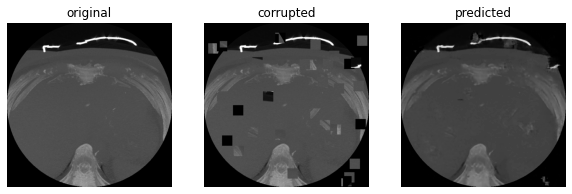

Epoch 72/500
51/51 [==============================] - 17s 333ms/step - loss: 2.0499e-04 - val_loss: 4.7436e-04
Epoch 73/500
51/51 [==============================] - 17s 333ms/step - loss: 1.9587e-04 - val_loss: 4.7768e-04
Epoch 74/500
51/51 [==============================] - 17s 333ms/step - loss: 2.1422e-04 - val_loss: 4.6703e-04
Epoch 75/500
51/51 [==============================] - 17s 334ms/step - loss: 2.1370e-04 - val_loss: 5.4728e-04
Epoch 76/500
51/51 [==============================] - 17s 337ms/step - loss: 2.3196e-04 - val_loss: 4.9799e-04


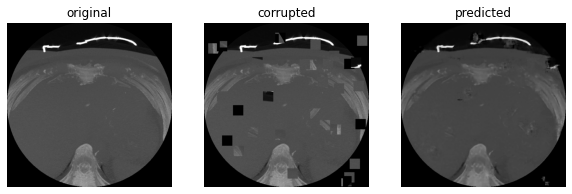

Epoch 77/500
51/51 [==============================] - 17s 334ms/step - loss: 2.0433e-04 - val_loss: 4.8047e-04
Epoch 78/500
 6/51 [==>...........................] - ETA: 13s - loss: 2.1674e-04

KeyboardInterrupt: 

In [11]:
history = model.fit(X_train, y_train, epochs=500, batch_size=8, validation_data=(X_test, y_test), callbacks=custom_callbacks)

In [14]:
modelName = 'models/' + MODEL_NAME
model.save(modelName)

INFO:tensorflow:Assets written to: models/alpha_model/assets


## Evaluation

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [15]:
exclude=['models/medium_model_LR_0.001_2/image.png','models/medium_model_LR_0.001_2/image_corrupt.png']
reconstructed = glob('models/medium_model_LR_0.001_2/*.png')
reconstructed = [r for r in reconstructed if r not in exclude]
reconstructed.sort()

images = []
for image_path in reconstructed:
    im = plt.imread(image_path)
    images.append(plt.imread(image_path))
images = np.array(images)
reconstructed

['models/medium_model_LR_0.001_2/000000.png',
 'models/medium_model_LR_0.001_2/000005.png',
 'models/medium_model_LR_0.001_2/000010.png',
 'models/medium_model_LR_0.001_2/000015.png',
 'models/medium_model_LR_0.001_2/000020.png',
 'models/medium_model_LR_0.001_2/000025.png',
 'models/medium_model_LR_0.001_2/000030.png',
 'models/medium_model_LR_0.001_2/000035.png',
 'models/medium_model_LR_0.001_2/000040.png',
 'models/medium_model_LR_0.001_2/000045.png',
 'models/medium_model_LR_0.001_2/000050.png',
 'models/medium_model_LR_0.001_2/000055.png',
 'models/medium_model_LR_0.001_2/000060.png',
 'models/medium_model_LR_0.001_2/000065.png',
 'models/medium_model_LR_0.001_2/000070.png',
 'models/medium_model_LR_0.001_2/000075.png']

In [16]:
%%time

Figure = plt.figure()
 
# creating a plot
lines_plotted = plt.imshow(images[0], cmap=plt.cm.gray)    

# function takes frame as an input
def AnimationFunction(frame):
 
    # setting y according to frame
    # number and + x. It's logic
    plt.imshow(images[frame], cmap=plt.cm.gray)
     
anim = FuncAnimation(Figure, AnimationFunction, frames=images.shape[0], interval=100)

writervideo = animation.FFMpegWriter(fps=10)
# anim.save('videos/TrainingsVideo.mp4', writervideo)

video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)

plt.close()

CPU times: user 4.79 s, sys: 0 ns, total: 4.79 s
Wall time: 4.98 s
